New York Taxi 
![](http://www.nyc.gov/html/tlc/images/features/fi_industry_yellow_taxi_photo.jpg)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline 

import folium

from sklearn import metrics
from sklearn import metrics
from scipy.stats import zscore

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv', 'test.csv']


In [3]:
# Helping functions from Jeff Heaton's course on Deep Learning
# https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class06_backpropagation.ipynb
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [4]:
# Date parser is used to treat the date and time column data as dates
data_train = pd.read_csv('../input/train.csv', nrows = 5_000_000, parse_dates=['pickup_datetime'])
data_train.head()

key       ...         passenger_count
0    2009-06-15 17:26:21.0000001       ...                       1
1    2010-01-05 16:52:16.0000002       ...                       1
2   2011-08-18 00:35:00.00000049       ...                       2
3    2012-04-21 04:30:42.0000001       ...                       1
4  2010-03-09 07:51:00.000000135       ...                       1

[5 rows x 8 columns]

In [5]:
data_train.describe()

# Note that there are negative fares and very large amount of fares too. 
# Longitude and Latitude are negative and also very large which is incorrrect. 

fare_amount       ...         passenger_count
count  5.000000e+06       ...            5.000000e+06
mean   1.134080e+01       ...            1.684695e+00
std    9.820175e+00       ...            1.331854e+00
min   -1.000000e+02       ...            0.000000e+00
25%    6.000000e+00       ...            1.000000e+00
50%    8.500000e+00       ...            1.000000e+00
75%    1.250000e+01       ...            2.000000e+00
max    1.273310e+03       ...            2.080000e+02

[8 rows x 6 columns]

In [6]:
data_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

Text(0.5,1,'Variation of Taxi Fare Amount in New York')

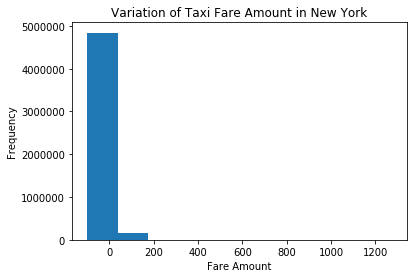

In [7]:
data_train['fare_amount'].plot(kind='hist')
plt.xlabel('Fare Amount')
plt.title('Variation of Taxi Fare Amount in New York')

****Data Cleanup****

During this step, the data is cleaned by removing the outliers such as 
* Data with large fares,
* Data with negative fares and negligible fares below 50 cents
* Data with same starting to ending locations
* Any null/na fields
* Data with pickup/drop off beyond NY city limits
* Data with negative person count

In [8]:
# Checking number of rides with fare over $100
data_train_filtered = data_train[data_train['fare_amount'] >100]
percent_data_train_filtered = data_train_filtered.shape[0]/data_train.shape[0]*100
print('Number of fares greater than $100 are,',data_train_filtered.shape[0])
print('Percentage of fares greater than 100 ', percent_data_train_filtered)

Number of fares greater than $100 are, 1977
Percentage of fares greater than 100  0.03954


In the next step, fares greater than \$100 as well as smaller than \$2.50 are dropped as being outliers. Please note that $2.50 is minimum fare. 

In [9]:
Nrows = data_train.shape[0]
print ('Number of rows in training data before cleaning are, {}'.format(Nrows))

# Remove the outliers of pickup longitudes different than thse values which are bounding box of New York City
# North Latitude: 40.917577 South Latitude: 40.477399 East Longitude: -73.700272 West Longitude: -74.259090
# source https://www.mapdevelopers.com/geocode_bounding_box.php
data_train = data_train[data_train['dropoff_latitude'] <=40.917577]
data_train = data_train[data_train['dropoff_latitude'] >=40.477399]
           
data_train = data_train[data_train['pickup_latitude'] <=40.917577]
data_train = data_train[data_train['pickup_latitude'] >=40.477399]

data_train = data_train[data_train['dropoff_longitude'] <=-73.700272]
data_train = data_train[data_train['dropoff_longitude'] >=-74.259090]
           
data_train = data_train[data_train['pickup_longitude'] <=-73.700272]
data_train = data_train[data_train['pickup_longitude'] >=-74.259090]

# Keep rows only with different starting and ending location
data_train = data_train[data_train['dropoff_latitude'] != data_train['pickup_latitude']]
data_train = data_train[data_train['dropoff_longitude'] != data_train['pickup_longitude']]

# Replace missing rows with no fare amount with median value
missing_median(data_train,'fare_amount')

# Removing the outliers of fare amount more than standard deviation of 3.
#remove_outliers(data_train,'fare_amount', sd=3)

# Dropping fares greater than $100
data_train = data_train[data_train['fare_amount']<100]

# Keep rows only with non-negative fare and non-negligible erronous amount
data_train = data_train[data_train['fare_amount']>=2.5]

# Keep rows only with non-negative fare and non-negligible erronous amount
data_train = data_train[data_train['passenger_count']>0]
data_train = data_train[data_train['passenger_count']<7]

print("Removing outliers with fare more than $100, negative fares, outside of boundary of NY city,negative passengers and missing na values")
Nrows_clean = data_train.shape[0]
PercLost = (Nrows-Nrows_clean)/Nrows*100
print ('Number of rows in data after cleaning are, {}'.format(Nrows_clean))
print ('Percentage of data removed after cleaning {}.format',PercLost)

Number of rows in training data before cleaning are, 5000000
Removing outliers with fare more than $100, negative fares, outside of boundary of NY city,negative passengers and missing na values
Number of rows in data after cleaning are, 4817446
Percentage of data removed after cleaning {}.format 3.6510800000000003


In [10]:
data_train.describe()

fare_amount       ...         passenger_count
count  4.817446e+06       ...            4.817446e+06
mean   1.127274e+01       ...            1.690806e+00
std    9.273671e+00       ...            1.306303e+00
min    2.500000e+00       ...            1.000000e+00
25%    6.000000e+00       ...            1.000000e+00
50%    8.500000e+00       ...            1.000000e+00
75%    1.250000e+01       ...            2.000000e+00
max    9.999000e+01       ...            6.000000e+00

[8 rows x 6 columns]

In [11]:
# Count if any data is null or zero
print(data_train.isnull().sum())


key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [12]:
# Drop the data with null longitude
data_train = data_train[~data_train.dropoff_longitude.isnull()]
print(data_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [13]:
import folium
NY_CORD = (data_train['pickup_latitude'].mean(),data_train['pickup_longitude'].mean())
max_records = 1000

ny_map = folium.Map(location=NY_CORD, zoom_start=12.0,tiles= "OpenStreetMap")
for each in data_train[:max_records].iterrows():
    folium.CircleMarker(
        radius = 4,
        color ='red',
        location = [each[1]['pickup_latitude'],each[1]['pickup_longitude']],
        popup='lat='+str(each[1]['pickup_latitude'])+',long='+str(each[1]['pickup_longitude'])
    ).add_to(ny_map)
ny_map

In [14]:
import folium
NY_CORD = (data_train['pickup_latitude'].mean(),data_train['pickup_longitude'].mean())
max_records = 1000

ny_map2 = folium.Map(location=NY_CORD, zoom_start=11.0,tiles= "OpenStreetMap")
for each in data_train[:max_records].iterrows():
    folium.CircleMarker(
        radius = 4,
        color ='blue',
        location = [each[1]['dropoff_latitude'],each[1]['dropoff_longitude']],
        popup='lat='+str(each[1]['dropoff_latitude'])+',long='+str(each[1]['dropoff_longitude'])
    ).add_to(ny_map2)
ny_map2

**Feature Engineering**

In this section, new features are created from locations of pickup/dropoff and time data. They allow us to look more closely into effect of these new variables on fare. 

It is also necessary to consider the fare methods used by New York Taxi and Limosine Commission. 

* As per which, there is a surcharge of \$1 for taxi pickup between peak hours, Monday - Friday after 4:00 PM & before 8:00 PM. 
* In addition, there is a night surcharge of \$0.50 after 8:00 PM & before 6:00 AM. This means we need to create a feature for this. 
* There is also a flat fare plus toll charges plus surcharges for pickups to and from between JFK and Manhatten.  
* There is a also a fixed surcharge of $17.5 for dropoff to Newark airport. 

Using the pickup and dropoff locations, distance can be Haversine distance can be calculated. 
Similarly date-time time is split into the 
* Year - to capture year over year increase in the taxi fare, 
* Day of the year -  to capture the effect of seasonal weather changes on taxi fares,
* Day of the week - to capture effect of weekly patterns on taxi fare, such as work week Vs weekend
* Time of the day - to capture effect of daily work schedules on taxi fares

In [15]:
# Calculate the distance between two latitude and longitude data points using Haversine method
# https://en.wikipedia.org/wiki/Haversine_formula
# https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula

# Bearing calculated using method - https://www.movable-type.co.uk/scripts/latlong.html 
# http://mathforum.org/library/drmath/view/55417.html
    
import math
    
def getDistance(df):
    R_Earth = 6371 # Radius of earth in km
    LAT1 = df['pickup_latitude'] 
    LONG1 = df['pickup_longitude']
    LAT2 = df['dropoff_latitude']
    LONG2 = df['dropoff_longitude']
    dLat = deg2rad(LAT2 - LAT1)
    dLon = deg2rad(LONG2 - LONG1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(deg2rad(LAT1)) * math.cos(deg2rad(LAT2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * np.arcsin(np.sqrt(a)); 
    return R_Earth*c

def getBearing(df):
    R_Earth = 6371 # Radius of earth in km
    LAT1 = deg2rad( df['pickup_latitude'] )
    LONG1 = deg2rad(  df['pickup_longitude'] )
    LAT2 = deg2rad( df['dropoff_latitude']  )
    LONG2 = deg2rad( df['dropoff_longitude'] )
    dLat = (LAT2 - LAT1)
    dLon = (LONG2 - LONG1)
    a = np.arctan2(np.sin(dLon * np.cos(LAT2)),np.cos(LAT1) * np.sin(LAT2) - np.sin(LAT1) * np.cos(LAT2) * np.cos(dLon))
    return a

def deg2rad(deg):
    return np.radians(deg)

In [16]:
data_train.drop('key',1, inplace=True)

data_train['distance_km'] = data_train.apply(getDistance, axis=1)
data_train['bearing'] = data_train.apply(getBearing, axis=1)

def split_time(df):
    data_train['year'] = data_train.pickup_datetime.dt.year
    data_train['month'] = data_train.pickup_datetime.dt.month
    data_train['day_of_year'] = data_train.pickup_datetime.dt.dayofyear
    data_train['hour'] = data_train.pickup_datetime.dt.hour
    data_train['day_of_week'] = data_train.pickup_datetime.dt.dayofweek
    
split_time(data_train)

data_train.head()

fare_amount     pickup_datetime     ...       hour  day_of_week
0          4.5 2009-06-15 17:26:21     ...         17            0
1         16.9 2010-01-05 16:52:16     ...         16            1
2          5.7 2011-08-18 00:35:00     ...          0            3
3          7.7 2012-04-21 04:30:42     ...          4            5
4          5.3 2010-03-09 07:51:00     ...          7            1

[5 rows x 14 columns]

To consider the peak hour and late night fares new features are created. 

In [17]:
def peak_hour(df):
    if df['hour']>=16 and df['hour']<=20:
        return 1
    else:
        return 0

def night_hour(df):
    if df['hour']>=20 or df['hour']<=6:
        return 1
    else:
        return 0

def JFK_Manhatten_pickup_drop(df):
    # Range of co-ordinates for JFK airport which have fixed surcharge
    if (40.6214 <= df['pickup_latitude'] <= 40.6693) and (-73.8250 <= df['pickup_longitude'] <= -73.7459) \
        and (40.7002 <= df['dropoff_latitude'] <= 40.7655) and (-74.0217 <= df['dropoff_longitude'] <= -73.9495) and df['fare_amount']>51:
            return 1
    elif (40.7002 <= df['pickup_latitude'] <= 40.7655) and (-74.0217 <= df['pickup_longitude'] <= -73.9495) \
        and (40.6214 <= df['dropoff_latitude'] <= 40.6693) and (-73.8250 <= df['dropoff_longitude'] <= -73.7459) and df['fare_amount']>51:
            return 1
    elif (40.6214 <= df['pickup_latitude'] <= 40.6693) and (-73.8250 <= df['pickup_longitude'] <= -73.7459) \
        and (40.7663 <= df['dropoff_latitude'] <= 40.8316) and (-73.9908 <= df['dropoff_longitude'] <= -73.9185) and df['fare_amount']>51: 
            return 1
    elif (40.7663 <= df['pickup_latitude'] <= 40.8316) and (-73.9908 <= df['pickup_longitude'] <= -73.9185) \
        and (40.6214 <= df['dropoff_latitude'] <= 40.6693) and (-73.8250 <= df['dropoff_longitude'] <= -73.7459) and df['fare_amount']>51:
            return 1
    else:
        return 0
    

def NEW_airport_dropoff(df):
    # Range of co-ordinates for Newark airport which have fixed surcharge
    if ( (40.6694 <= df['dropoff_latitude'] <= 40.7049) and  (-74.1935 <= df['dropoff_longitude'] <= -74.1508)):
        return 1
    else:
        return 0

data_train['peak'] = data_train.apply(peak_hour,axis=1)
data_train['night_hour'] = data_train.apply(night_hour,axis=1)
data_train['JFK_airport'] = data_train.apply(JFK_Manhatten_pickup_drop, axis=1)
data_train['NEW_airport'] = data_train.apply(NEW_airport_dropoff, axis=1)


data_train.head()

fare_amount     pickup_datetime     ...       JFK_airport  NEW_airport
0          4.5 2009-06-15 17:26:21     ...                 0            0
1         16.9 2010-01-05 16:52:16     ...                 0            0
2          5.7 2011-08-18 00:35:00     ...                 0            0
3          7.7 2012-04-21 04:30:42     ...                 0            0
4          5.3 2010-03-09 07:51:00     ...                 0            0

[5 rows x 18 columns]

In [18]:
data_train.describe()

fare_amount  pickup_longitude      ...        JFK_airport   NEW_airport
count  4.817446e+06      4.817446e+06      ...       4.817446e+06  4.817446e+06
mean   1.127274e+01     -7.397567e+01      ...       7.111237e-03  1.281384e-03
std    9.273671e+00      3.406761e-02      ...       8.402779e-02  3.577349e-02
min    2.500000e+00     -7.425882e+01      ...       0.000000e+00  0.000000e+00
25%    6.000000e+00     -7.399228e+01      ...       0.000000e+00  0.000000e+00
50%    8.500000e+00     -7.398213e+01      ...       0.000000e+00  0.000000e+00
75%    1.250000e+01     -7.396852e+01      ...       0.000000e+00  0.000000e+00
max    9.999000e+01     -7.370058e+01      ...       1.000000e+00  1.000000e+00

[8 rows x 17 columns]

**Exploring The Data**

In this section, effect of various variables on fare amount is analyzed. 

Text(0.5,1,'Variation of Taxi Fare Amount in New York')

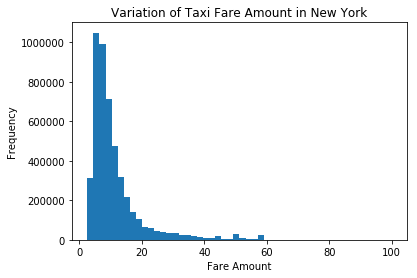

In [19]:
data_train['fare_amount'].plot(kind='hist', bins=50)
plt.xlabel('Fare Amount')
plt.title('Variation of Taxi Fare Amount in New York')

Text(0.5,1,'Variation of Ride Distance for a taxi in New York')

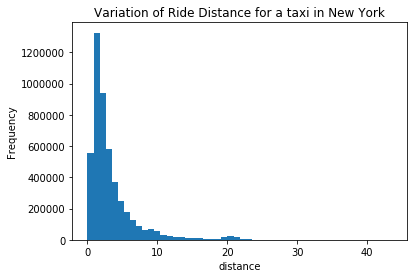

In [20]:
data_train['distance_km'].plot(kind='hist', bins=50)
plt.xlabel('distance')
plt.title('Variation of Ride Distance for a taxi in New York')

Text(0,0.5,'Fare ($)')

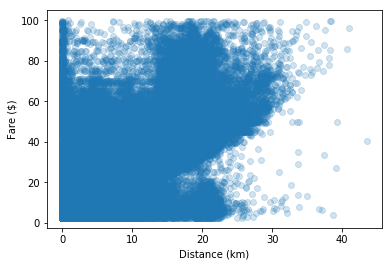

In [21]:
plt.scatter(data_train['distance_km'],data_train['fare_amount'],alpha=0.2)
plt.xlabel('Distance (km)')
plt.ylabel('Fare ($)')

In [22]:
# Plotting airport rides in a map to confirm location of pickup
data_train_airport = data_train[data_train['JFK_airport'] == 1]

#data_train_airport.head(20)
(data_train_airport.describe())
# Note that mean fare is around the minimum fare for the ride is 2.5 though minimum is $52.00
# Mean value is correct, so we have drop the values which are below $52

fare_amount  pickup_longitude     ...       JFK_airport  NEW_airport
count  34258.000000      34258.000000     ...           34258.0      34258.0
mean      56.175271        -73.865444     ...               1.0          0.0
std        2.493849          0.097374     ...               0.0          0.0
min       51.070000        -74.018692     ...               1.0          0.0
25%       56.800000        -73.978668     ...               1.0          0.0
50%       57.330000        -73.789976     ...               1.0          0.0
75%       57.330000        -73.782935     ...               1.0          0.0
max       99.000000        -73.747160     ...               1.0          0.0

[8 rows x 17 columns]

In [23]:
import folium
JFK_CORD = (data_train_airport['pickup_latitude'].mean(),data_train_airport['pickup_longitude'].mean())
max_records = 1000

airport_map = folium.Map(location=JFK_CORD, zoom_start=12.0,tiles= "OpenStreetMap")

for each in data_train_airport[:max_records].iterrows():
    folium.CircleMarker(
        radius = 4,
        color ='red',
        location = [each[1]['pickup_latitude'],each[1]['pickup_longitude']],
        popup='lat='+str(each[1]['pickup_latitude'])+',long='+str(each[1]['pickup_longitude'])
    ).add_to(airport_map)
airport_map


Text(0.5,1,'Taxi Fare for rides between Manhatten and JFK')

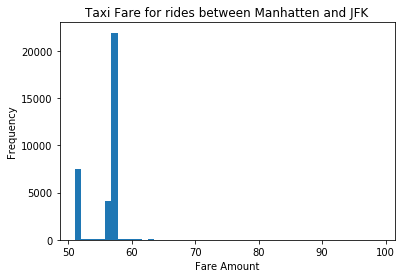

In [24]:
data_train_airport['fare_amount'].plot(kind='hist', bins=50)
plt.xlabel('Fare Amount')
plt.title('Taxi Fare for rides between Manhatten and JFK')

<Figure size 1440x1440 with 0 Axes>

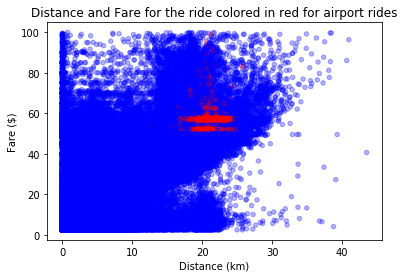

In [25]:
colors = np.where(data_train["JFK_airport"]==1,'r','b')
data_train.plot.scatter('distance_km', 'fare_amount',c=colors,alpha=0.3)
plt.xlabel('Distance (km)')
plt.ylabel('Fare ($)')
plt.title('Distance and Fare for the ride colored in red for airport rides')
plt.Figure(figsize=(20, 20))

In [26]:
# Newark Airport Dropoff
# Plotting airport rides in a map to confirm location of pickup
data_train_nw_airport = data_train[data_train['NEW_airport'] == 1]

#data_train_airport.head(20)
(data_train_nw_airport.describe())
# Note that mean fare is around the minimum fare for the ride is 2.5 though minimum is $52.00
# Mean value is correct, so we have drop the values which are below $52

fare_amount  pickup_longitude     ...       JFK_airport  NEW_airport
count  6173.000000       6173.000000     ...            6173.0       6173.0
mean     69.850601        -73.992095     ...               0.0          1.0
std      14.440396          0.040948     ...               0.0          0.0
min       2.500000        -74.194223     ...               0.0          1.0
25%      62.700000        -73.997665     ...               0.0          1.0
50%      70.250000        -73.985722     ...               0.0          1.0
75%      79.500000        -73.977737     ...               0.0          1.0
max      99.800000        -73.776712     ...               0.0          1.0

[8 rows x 17 columns]

In [27]:
import folium
NEW_CORD = (data_train_nw_airport['dropoff_latitude'].mean(),data_train_nw_airport['dropoff_longitude'].mean())
max_records = 1000

airport_map = folium.Map(location=NEW_CORD, zoom_start=12.0,tiles= "OpenStreetMap")

for each in data_train_nw_airport[:max_records].iterrows():
    folium.CircleMarker(
        radius = 4,
        color ='red',
        location = [each[1]['dropoff_latitude'],each[1]['dropoff_longitude']],
        popup='lat='+str(each[1]['dropoff_latitude'])+',long='+str(each[1]['dropoff_longitude'])
    ).add_to(airport_map)
airport_map

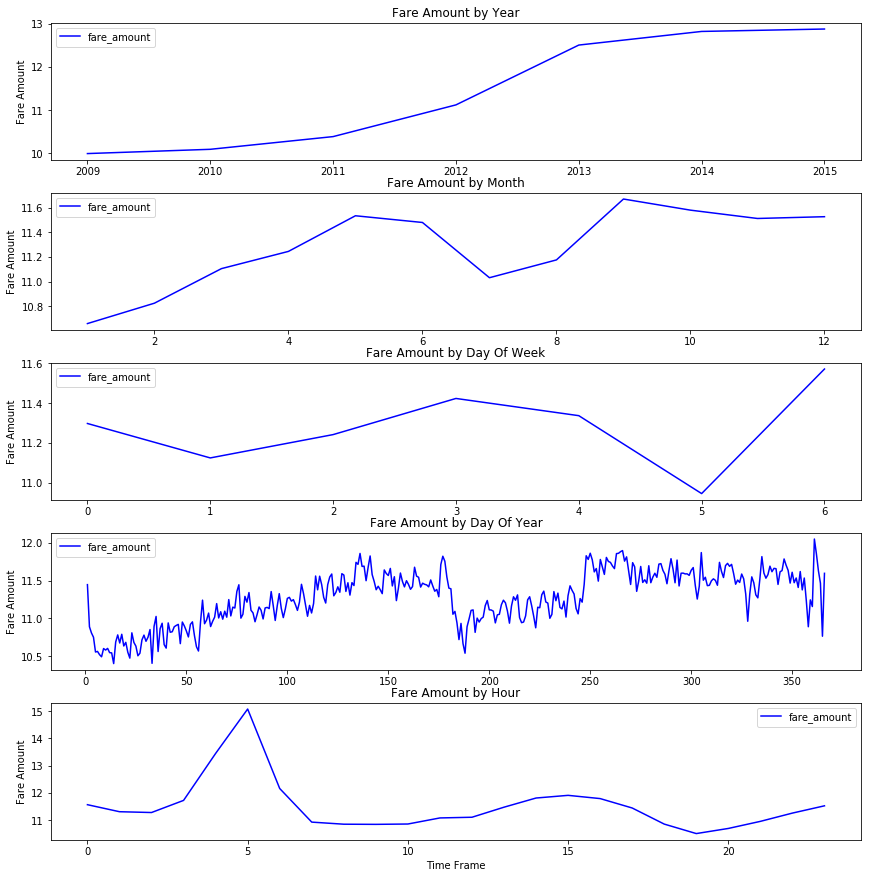

In [28]:
# Reference for this analysis https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm
def plot_time_history(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)

plot_time_history(df=data_train, timeframes=['year',"month","day_of_week","day_of_year","hour"], value = "fare_amount", color="blue")
    

**Baseline Model Development: 
**

1. Separate features and target variables (Fare)
2. Feature scalling : Scale the data of passenger, year, distance, hour, day
3. Data will be split into two sets primarily training, validation and testing data.
4. Baseling model with sklearn


In [29]:
# Convert LAT/LONG to radians after plotting is done
data_train['pickup_latitude']=deg2rad(data_train['pickup_latitude'])
data_train['pickup_longitude']=deg2rad(data_train['pickup_longitude'])
data_train['dropoff_longitude']=deg2rad(data_train['dropoff_longitude'])
data_train['dropoff_latitude']=deg2rad(data_train['dropoff_latitude'])

In [30]:
data_train.head()

fare_amount     pickup_datetime     ...       JFK_airport  NEW_airport
0          4.5 2009-06-15 17:26:21     ...                 0            0
1         16.9 2010-01-05 16:52:16     ...                 0            0
2          5.7 2011-08-18 00:35:00     ...                 0            0
3          7.7 2012-04-21 04:30:42     ...                 0            0
4          5.3 2010-03-09 07:51:00     ...                 0            0

[5 rows x 18 columns]

In [31]:
data_train.drop('pickup_datetime',1, inplace=True)

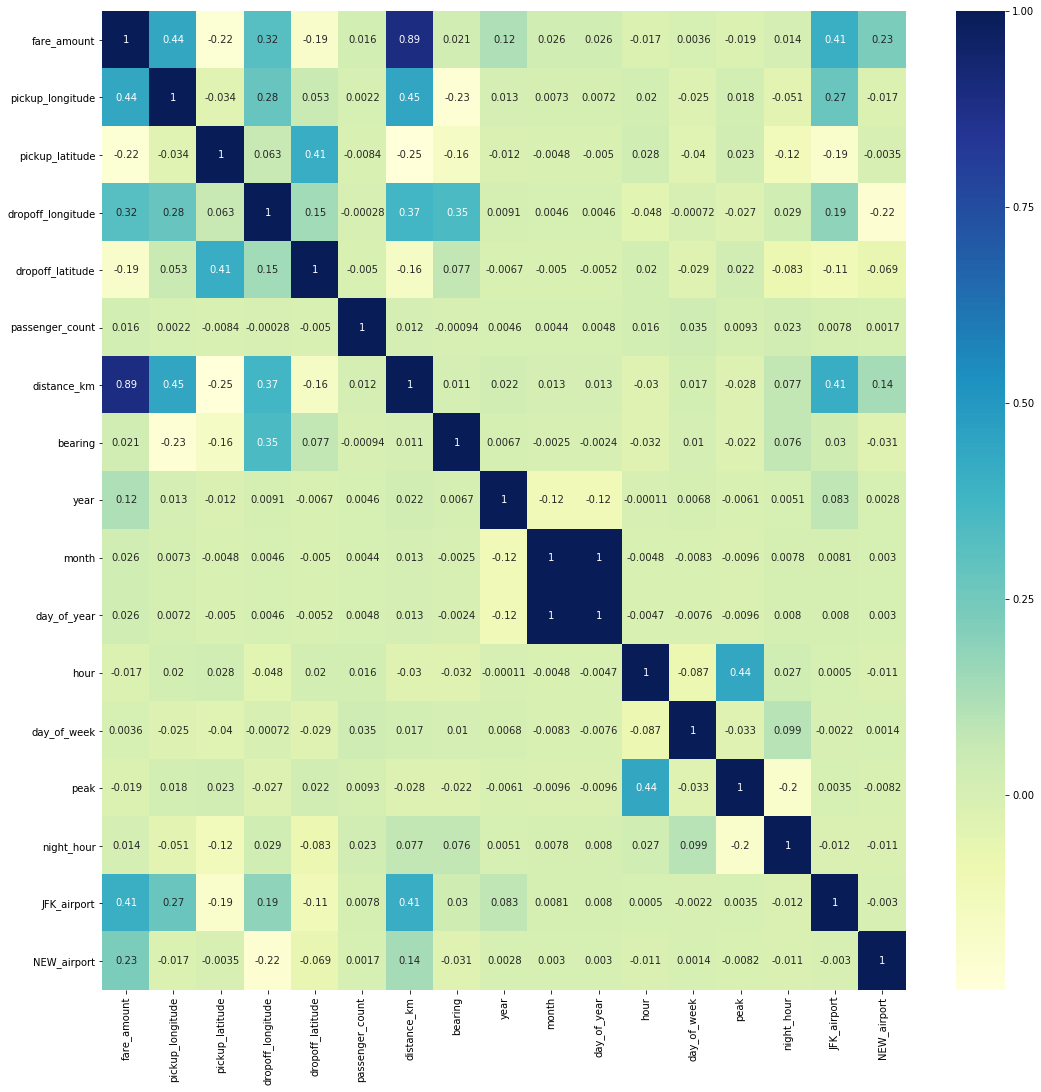

In [32]:
import seaborn as sns

cm = data_train.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(cm, xticklabels=data_train.columns, yticklabels=data_train.columns, annot=True, cmap="YlGnBu")

In [33]:
# Separate features from target variable
fare = data_train['fare_amount']
features = data_train.drop('fare_amount', axis = 1)

# Drop columns of LAT, LONG, Month, Day of the week, day of the year as they do not influence the fare but demand
# Hour is dropped because it is transformed into peak hour or late night
#features.drop('pickup_latitude',1, inplace=True)
#features.drop('pickup_longitude',1, inplace=True)
#features.drop('dropoff_latitude',1, inplace=True)
#features.drop('dropoff_longitude',1, inplace=True)
#features.drop('pickup_datetime',1, inplace=True)
features.drop('day_of_year',1, inplace=True)
features.drop('day_of_week',1, inplace=True)
features.drop('month',1, inplace=True)
features.drop('hour',1, inplace=True)

In [34]:
features.head()

pickup_longitude  pickup_latitude     ...       JFK_airport  NEW_airport
0         -1.288826         0.710721     ...                 0            0
1         -1.291824         0.710546     ...                 0            0
2         -1.291242         0.711418     ...                 0            0
3         -1.291319         0.710927     ...                 0            0
4         -1.290987         0.711536     ...                 0            0

[5 rows x 12 columns]

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

#print(features_scaled[0])

scaled_df = pd.DataFrame(features_scaled, columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',\
                                             'passenger_count','distance_km','bearing','year','peak','night_hour',
                                             'JFK_airport','NEW_airport'])
#scaled_df.head()
scaled_df.describe()

pickup_longitude      ...        NEW_airport
count      4.817446e+06      ...       4.817446e+06
mean       5.072264e-01      ...       1.281384e-03
std        6.102692e-02      ...       3.577349e-02
min        0.000000e+00      ...       0.000000e+00
25%        4.774586e-01      ...       0.000000e+00
50%        4.956443e-01      ...       0.000000e+00
75%        5.200371e-01      ...       0.000000e+00
max        1.000000e+00      ...       1.000000e+00

[8 rows x 12 columns]

In [36]:
# Data splitting with sklearn train_test_split and 10% of the data is reserved for testing
from sklearn.model_selection import train_test_split

X_train1, X_hold, y_train1, y_hold = train_test_split(features_scaled, 
                                                    fare, 
                                                    test_size = 0.1, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train1.shape[0]))
print("Holdout set has {} samples.".format(X_hold.shape[0]))


Training set has 4335701 samples.
Holdout set has 481745 samples.


In [37]:
# Data splitting with sklearn train_test_split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train1, 
                                                    y_train1, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_val.shape[0]))

Training set has 3468560 samples.
Validation set has 867141 samples.


In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from math import sqrt

Reg_model = LinearRegression()
Reg_model.fit(X_train, y_train)
y_pred = Reg_model.predict(X_hold)

error = math.sqrt(mean_squared_error(y_pred,y_hold))
print (f'Root mean squared error is {error}')

error = mean_absolute_error(y_pred,y_hold)
print (f'Mean absolute error is {error}')

Root mean squared error is 3.9399132046531022
Mean absolute error is 2.1152364926032248


In [39]:
print ('Coefficients of the linear model are',Reg_model.coef_)
print('Intercept of the model is',Reg_model.intercept_)
print (f'R2 Score of the model is {Reg_model.score(X_hold, y_hold)}')

Coefficients of the linear model are [ 1.01314675e+01  2.72528492e+00  6.17923809e-01 -7.83786157e+00
  2.19653858e-01  9.34031319e+01  1.22110472e+00  2.91333012e+00
 -7.21983896e-02 -9.97065583e-01  4.35946713e+00  2.89478699e+01]
Intercept of the model is 0.2393367582399577
R2 Score of the model is 0.8187228271098629


coef  positive
dropoff_latitude   -7.837862     False
night_hour         -0.997066     False
peak               -0.072198     False
passenger_count     0.219654      True
dropoff_longitude   0.617924      True
bearing             1.221105      True
pickup_latitude     2.725285      True
year                2.913330      True
JFK_airport         4.359467      True
pickup_longitude   10.131467      True
NEW_airport        28.947870      True
distance_km        93.403132      True

Intercept: 0.2393367582399577


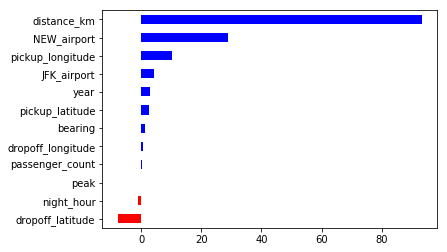

In [40]:
#Reference https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class09_regularization.ipynb

# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
names=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',\
                                             'passenger_count','distance_km','bearing','year','peak','night_hour',
                                             'JFK_airport','NEW_airport']   
report_coef(
  names,
  Reg_model.coef_,
  Reg_model.intercept_)

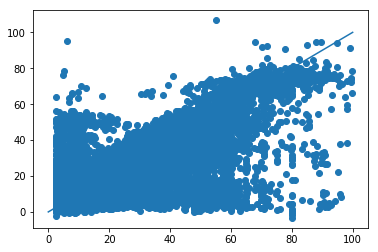

In [41]:
plt.scatter(y_hold, y_pred)
x = np.linspace(0, 100, 100)
y = x
plt.plot(x, y)
plt.show()

# reference:https://www.kaggle.com/andyxie/beginner-scikit-learn-linear-regression-tutorial

**Predicting Fares with Deep Learning Model with Tensorflow and Keras
**

Following will be parameters of the model used for tuning the model

* Plot validation loss curve
* Learning rate
* Number of deep layers
* Number of neurons in layers
* Add dropout layers
* Change initial values
* Batch gradient descent for large data

In [42]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras import regularizers


# Build the neural network
model = Sequential()

model.add(Dense(256,input_dim=X_train.shape[1],activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu'))

model.add(Dense(1))

sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3328      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [43]:
from keras.callbacks import LearningRateScheduler

monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=5, verbose=0, mode='auto')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001,cooldown=5)

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

history = model.fit(X_train,y_train,validation_data=(X_val,y_val), callbacks=[monitor], batch_size = 250, verbose=1, epochs=1000)


Train on 3468560 samples, validate on 867141 samples
Epoch 1/1000
3468560/3468560 [==============================] - 161s 47us/step - loss: 26.1311 - val_loss: 16.3737
Epoch 2/1000
3468560/3468560 [==============================] - 157s 45us/step - loss: 16.4124 - val_loss: 15.0081
Epoch 3/1000
3468560/3468560 [==============================] - 158s 46us/step - loss: 15.4006 - val_loss: 14.3145
Epoch 4/1000
3468560/3468560 [==============================] - 158s 45us/step - loss: 14.9485 - val_loss: 14.0401
Epoch 5/1000
3468560/3468560 [==============================] - 158s 46us/step - loss: 14.6181 - val_loss: 14.2521
Epoch 6/1000
3468560/3468560 [==============================] - 157s 45us/step - loss: 14.4184 - val_loss: 13.2921
Epoch 7/1000
3468560/3468560 [==============================] - 158s 46us/step - loss: 14.2510 - val_loss: 13.8651
Epoch 8/1000
3468560/3468560 [==============================] - 158s 45us/step - loss: 14.1395 - val_loss: 13.3759
Epoch 9/1000
3468560/346856

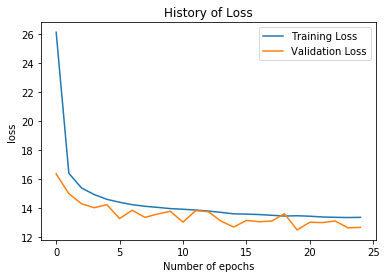

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('History of Loss')
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend() 

In [45]:
# Making predictions
prediction = model.predict(X_hold)

# Check how good are predictions with RMS calculation
RMS = np.sqrt(metrics.mean_squared_error(prediction,y_hold))

print(f'Model has RMS of : {RMS}')

Model has RMS of : 3.438880594121953


Optimzation of Hyperparameters
In this section, following hyperparameters are tuned to improve the accuracy of the model

* Batch size: Ranges from 250-500
* Dropout:  0-0.2

In [46]:
def CreatDeepNetwork(dropout_rate=0.0):
    # Build the neural network
    Gmodel = Sequential()
    Gmodel.add(Dense(256,input_dim=X_train.shape[1],activation='relu'))
    Gmodel.add(BatchNormalization())
    Gmodel.add(Dropout(dropout_rate))
    
    Gmodel.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    Gmodel.add(BatchNormalization())
    Gmodel.add(Dropout(dropout_rate))

    Gmodel.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    Gmodel.add(BatchNormalization())
    Gmodel.add(Dropout(dropout_rate))
    
    Gmodel.add(Dense(32,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu'))
    Gmodel.add(Dense(1))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    Gmodel.compile(loss='mean_squared_error', optimizer=adam)
    return Gmodel
#model.summary()

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

neural_network = KerasRegressor(build_fn=CreatDeepNetwork, verbose=0)
scoring_fnc = make_scorer(mean_squared_error,greater_is_better=False)
batch_size = [250, 500, 750]
dropout_rate =[0.0, 0.1, 0.2]

# Create hyperparameter options
hyperparameters = dict(batch_size=batch_size,dropout_rate=dropout_rate)

grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters, cv=None,scoring= scoring_fnc)



In [ ]:
#Fit grid search
grid_result = grid.fit(X_train,y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))